This notebook is based off of the [SGD mnist](https://github.com/fastai/fastai/blob/master/courses/ml1/lesson4-mnist_sgd.ipynb) lesson from fastai 

In this notebook we will start with a pytorch neural network implementation of logitistic regression and then program it ourselves

# Imports and Paths

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from data_sci.imports import *
from data_sci.utilities import *
from data_sci.fastai import *
from data_sci.fastai.dataset import *
from data_sci.fastai.metrics import *
from data_sci.fastai.torch_imports import *
from data_sci.fastai.model import *

import torch.nn as nn

Path to download the data

In [3]:
PATH = '/data/msnow/data_science/mnist/'

# MNIST Data

Let's download, unzip, and format the data.

In [4]:
URL='http://deeplearning.net/data/mnist/'
FILENAME='mnist.pkl.gz'

def load_mnist(filename):
    return pickle.load(gzip.open(filename, 'rb'), encoding='latin-1')

In [5]:
get_data(os.path.join(URL,FILENAME), os.path.join(PATH,FILENAME))
((x, y), (x_valid, y_valid), _) = load_mnist(os.path.join(PATH,FILENAME))

In [6]:
type(x), x.shape, type(y), y.shape

(numpy.ndarray, (50000, 784), numpy.ndarray, (50000,))

In [7]:
y_valid.shape

(10000,)

### Normalize

Many machine learning algorithms behave better when the data is *normalized*, that is when the mean is 0 and the standard deviation is 1. We will subtract off the mean and standard deviation from our training set in order to normalize the data:

In [8]:
mean = x.mean()
std = x.std()

x=(x-mean)/std
mean, std, x.mean(), x.std()

(0.13044983, 0.30728981, -3.1638146e-07, 0.99999934)

Note that for consistency (with the parameters we learn when training), we subtract the mean and standard deviation of our training set from our validation set. 

In [9]:
x_valid = (x_valid-mean)/std
x_valid.mean(), x_valid.std()

(-0.0058509219, 0.99243325)

### Look at the data

In [20]:
def plots(ims, figsize=(12,6), rows=2, titles=None):
    f = plt.figure(figsize=figsize)
    cols = len(ims)//rows
    for i in range(len(ims)):
        sp = f.add_subplot(rows, cols, i+1)
        sp.axis('Off')
        if titles is not None: sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i], cmap='gray')

In [11]:
x_valid.shape

(10000, 784)

In [19]:
y_valid.shape

(10000,)

The data has been reduced from a rank 3 tensor of image number by image width by image height to a rank 2 tensor of number of image number by pixel. Before visualizing the image we need to convert it back into a rank 3 tensor using numpy's `reshape`.  

`y_valid` is the list of integers which correspond to the images in `x_valid`

In [10]:
x_imgs = np.reshape(x_valid, (-1,28,28)); x_imgs.shape

(10000, 28, 28)

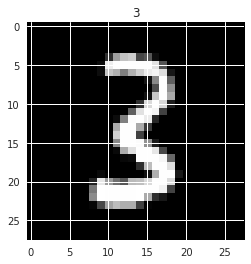

In [18]:
plt.imshow(x_imgs[0],cmap='gray')
plt.title(y_valid[0]);

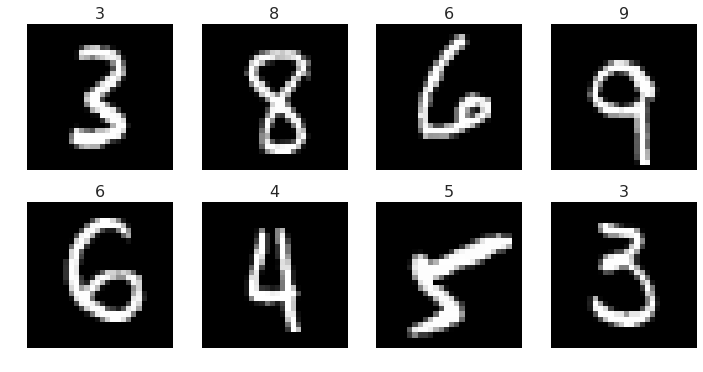

In [21]:
plots(x_imgs[:8], titles=y_valid[:8])

# Neural Networks

A **function** takes inputs and returns outputs.  The classic example is the equation for a line 

$$ f(x) = ax + b $$

where $x$ is the input, $a$ and $b$ are the **parameters** and $f(x)$ is the output.  A *neural network* is just a specific type of function (an *infinitely flexible function* to be exact), consisting of *layers*, which are made up of parameters.  A *layer* is a linear function such as matrix multiplication followed by a non-linear function (the *activation*).  For example, an equation for a simple neural network can be represented with the equation:

$$ f(\mathbf{x}) = a_{nl}\left(a_l \mathbf{x}\right) $$

where $\mathbf{x}$ is the input (the bold font just means that it is not just a scalar, i.e., it is a tensor of rank greater than 0), $a_l$ is the linear layer parameter, and $a_{nl}$ is the non linear layer parameter.

However, most neural networks are not nearly this simple.  They often have thousands, or even hundreds of thousands of parameters.  However the core idea is the same.  The neural network is a function, and we will learn the best parameters for modeling our data.

As an aside there always needs to be a non-linear function after each linear function, as multiple linear functions in a row can always be represented by a single linear function.  This is part of the definition of linear transformations.  For example, multiplying anything by 5 and then dividing the result by 2 is equivalent to multiplying the input by 5/2.

# PyTorch

PyTorch has two overlapping, yet distinct, purposes.  As described in the [PyTorch documentation](http://pytorch.org/tutorials/beginner/blitz/tensor_tutorial.html):

<img src="images/what_is_pytorch.png" alt="pytorch" style="width: 80%"/>

The neural network functionality of PyTorch is built on top of the Numpy-like functionality for fast matrix computations on a GPU. Although the neural network purpose receives way more attention, both are very useful.  We'll implement a neural net from scratch today using PyTorch.

**Further learning**: If you are curious to learn what *dynamic* neural networks are, you may want to watch [this talk](https://www.youtube.com/watch?v=Z15cBAuY7Sc) by Soumith Chintala, Facebook AI researcher and core PyTorch contributor.

If you want to learn more PyTorch, you can try this [introductory tutorial](http://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html) or this [tutorial to learn by examples](http://pytorch.org/tutorials/beginner/pytorch_with_examples.html).

# Use the built in Neural Net for Logistic Regression in PyTorch

We will begin with the highest level abstraction: using a neural net defined by PyTorch's Sequential class.  In PyTorch to switch between cpu and CUDA enabled gpu you just need to add `.cuda()` to the end of any nn architecture:

- GPU enabled
```python
net = nn.Sequential(
    nn.Linear(28*28, 10),
    nn.LogSoftmax()
).cuda()
```

- GPU disabled (using cpu)
```python
net = nn.Sequential(
    nn.Linear(28*28, 10),
    nn.LogSoftmax()
)
```

As we said above, each layer of the neural network is just the data modified first by a linear function and then by a non-linear function.  So if we wanted to build a neural network version of multinomial logistic regression, termed softmax in neural networks. Just as a reminder, here is the equation for softmax to predict the $j$-th class given a sample vector $\mathbf{x}$ and a weighting vector $\mathbf{w}$:

$$ Pr(y=j \mid  \mathbf{x}) = \dfrac{\exp\left(\mathbf{x}^T \mathbf{w}_j\right)}{\sum\limits_{k=1}^K\exp\left(\mathbf{x}^T\mathbf{w}_k\right)}$$

Each input is a vector of size `28*28` pixels and our output is of size `10` (since there are 10 digits: 0, 1, ..., 9). 

We use the output of the final layer to generate our predictions.  Often for classification problems (like MNIST digit classification), the final layer has the same number of outputs as there are classes.  In that case, this is 10: one for each digit from 0 to 9.  These can be converted to comparative probabilities.  For instance, it may be determined that a particular hand-written image is 80% likely to be a 4, 18% likely to be a 9, and 2% likely to be a 3.

So putting everything together, we want a layer composed of a linear component which converts our `28*28` rank 1 tensor (aka vector) inputs into an output rank 1 tensor of size `10` and then we want to apply a softmax classification function.

In [10]:
net = nn.Sequential(
    nn.Linear(28*28, 10),
    nn.LogSoftmax()
)

In [11]:
md = ImageClassifierData.from_arrays(PATH, (x,y), (x_valid, y_valid))

`ImageClassifierData` is from the [Fast AI library](https://github.com/fastai/fastai/blob/master/fastai/dataset.py) and calls a PyTorch data loader, which grabs a few images, sticks them into a mini-batch and makes them available, this is equivalent to a python generator.  You can call each of the different data loaders

- training data loader = md.trn_dl
- validation data loader = md.val_dl
- test data loader = md.test_dl
- augmented data loader = md.aug_dl
- test augemented data loader = md.test_aug_dl

## Aside about loss functions and metrics

In machine learning the **loss** function or cost function is representing the price paid for inaccuracy of predictions.  To understand where this loss function comes from let's take a little detour into probability theory. 

Given a fair coin what is the probability of the following outcomes:
 - Tails, Heads
 - Heads, Heads
 - Tails, Tails
You don't need any equations to know that the probability of each of those outcomes is 0.25, as there are four possible outcomes when you flip a coin twice, and if it is a fair coin the probability of each outcome is 0.25.  We can formalize this through the probability mass function (pmf) of the Bernoulli distribution:

$$
f(y;p) = p^y\left(1-p\right)^{1-y} \texttt{ for }k \in \{0,1\}
$$

where $y$ is the number of events occuring, $p$ is the probability of that event occuring and $f(y;p)$ is the probability of $y$ events occuring given $p$.  One way to determine the loss of this function is to take the negative log-likelihood (or cross-entropy) of our function.

\begin{align}
\ell\left(f\right) & = \log \left(p^y\left(1-p\right)^{1-y}\right)\\
&= \log \left(p^y\right) + \log\left(\left(1-p\right)^{1-y}\right)\\
&= y\log p + (1-y) \log (1-p)
\end{align}

In machine learning terms the equations are the same, but the terms means slightly different things.  For a given observation, $y$ is the true label and $p$ is the probability given by the model's prediction.


In [22]:
def binary_loss(y, p):
    return np.mean(-(y * np.log(p) + (1-y)*np.log(1-p)))

In [23]:
acts = np.array([1, 0, 0, 1])
preds = np.array([0.9, 0.1, 0.2, 0.8])
binary_loss(acts, preds)

0.164252033486018

Note that in our toy example above our accuracy is 100% and our loss is 0.16. 

Why not just maximize accuracy? The binary classification loss is an easier function to optimize.

For multi-class classification, we use *negative log liklihood* (also known as *categorical cross entropy*) which is exactly the same thing, but summed up over all classes.  For example, let's say we were trying to train a model to recognize pictures of animals, and the options were horse, dog, cat, lion, tiger, and bear.  We can represent each of the different options as a one hot encoded vectors:

|    |   horse |   dog |   cat |   lion |   tiger |   bear |
|---:|--------:|------:|------:|-------:|--------:|-------:|
|  0 |       1 |     0 |     0 |      0 |       0 |      0 |
|  1 |       0 |     1 |     0 |      0 |       0 |      0 |
|  2 |       0 |     0 |     1 |      0 |       0 |      0 |
|  3 |       0 |     0 |     0 |      1 |       0 |      0 |
|  4 |       0 |     0 |     0 |      0 |       1 |      0 |
|  5 |       0 |     0 |     0 |      0 |       0 |      1 |

let's say the model predicted the following output for a bear

|    |   bear |   predicted_bear |
|---:|-------:|-----------------:|
|  0 |      0 |             0.05 |
|  1 |      0 |             0.05 |
|  2 |      0 |             0.05 |
|  3 |      0 |             0.05 |
|  4 |      0 |             0.05 |
|  5 |      1 |             0.75 |

to calculate the loss for the prediction we look at the loss for each observation in the vector.

|    |   bear |   predicted_bear | loss_equation                     |   observation_loss |
|---:|-------:|-----------------:|:----------------------------------|-------------------:|
|  0 |      0 |             0.05 | 0\*log(0.05) + (1-0)\*log(1-0.05) |          0.0512933 |
|  1 |      0 |             0.05 | 0\*log(0.05) + (1-0)\*log(1-0.05) |          0.0512933 |
|  2 |      0 |             0.05 | 0\*log(0.05) + (1-0)\*log(1-0.05) |          0.0512933 |
|  3 |      0 |             0.05 | 0\*log(0.05) + (1-0)\*log(1-0.05) |          0.0512933 |
|  4 |      0 |             0.05 | 0\*log(0.05) + (1-0)\*log(1-0.05) |          0.0512933 |
|  5 |      1 |             0.75 | 1\*log(0.75) + (1-1)\*log(1-0.75) |          0.287682  |

The total loss for that prediction is the sum of the individual observation losses which comes out to 0.544

To understand this a little more, let's calculate the observation losses for a few more predictions


|    |   bear |   predict_1 |    loss_1 |   predict_2 |    loss_2 |   predict_3 |   loss_3 |
|---:|-------:|------------:|----------:|------------:|----------:|------------:|---------:|
|  0 |      0 |        0.05 | 0.0512933 |        0.01 | 0.0100503 |         0.1 | 0.105361 |
|  1 |      0 |        0.05 | 0.0512933 |        0.01 | 0.0100503 |         0.1 | 0.105361 |
|  2 |      0 |        0.05 | 0.0512933 |        0.01 | 0.0100503 |         0.1 | 0.105361 |
|  3 |      0 |        0.05 | 0.0512933 |        0.01 | 0.0100503 |         0.1 | 0.105361 |
|  4 |      0 |        0.05 | 0.0512933 |        0.01 | 0.0100503 |         0.1 | 0.105361 |
|  5 |      1 |        0.75 | 0.287682  |        0.95 | 0.0512933 |         0.5 | 0.693147 |

You can see that as the predictions get more accurate the individual observation losses decrease and vice versa as the predictions get less accurate.

This one-hot encoding for multiclass classification is why when  creating our nerual network above we built the layer to be (28,28,10).  The last value of the tuple is 10 to represent the 1 by 10 one-hot encoded vectors of the digits


## Now back to the model

As explained in the above aside, we want to use a negative log likelihood loss function for our model, `nn.NLLLoss()` in pytorch.  When evaluating our model we can use the accuracy.  For the optimization of our model we are going to use stochastic gradient descent, telling it to use the layers in `net` as the parameters, and setting other parameters which will be explained in other notebooks

In [12]:
loss=nn.NLLLoss()
metrics=[accuracy]
opt=optim.SGD(net.parameters(), 1e-1, momentum=0.9)

## Fitting the model

*Fitting* is the process by which the neural net learns the best parameters for the dataset.

In [13]:
fit(net, md, n_epochs=1, crit=loss, opt=opt, metrics=metrics)

epoch      trn_loss   val_loss   accuracy   
    0      1.301665   1.140233   0.8873    



[1.140232567659393, 0.88729999999999998]

GPUs are great at handling lots of data at once.  We break the data up into **batches**, and that specifies how many samples from our dataset we want to send to the processor (GPU or CPU) at a time.  The fastai library defaults to a batch size of 64.  On each iteration of the training loop, the error on 1 batch of data will be calculated, and the optimizer will update the parameters based on that.

An **epoch** is completed once each data sample has been used once in the training loop.

Now that we have the parameters for our model, we can make predictions on our validation set.

In [26]:
preds = predict(net, md.val_dl)

In [27]:
preds.shape

(10000, 10)

Our output is 10,000 by 10 because we have 10,000 observations in our validation set and 10 predictions per observation, i.e., prediction that it's a zero, prediction that it's a one, ...

To see how accurate our predictions are, we want to know how often the digit highest predicted matched the actual digit.  For now, we don't care about the actual value of the prediction, just the location of the highest prediction.

In [28]:
pd.DataFrame(preds[:3,:])

,0,1,2,3,4,5,6,7,8,9
0,-7.747974,-3.077208,-2.283786,-0.378413,-9.398509,-3.487280,-6.933934,-12.972561,-2.002663,-10.997322
1,-11.389916,-7.895541,-5.798741,-4.611126,-4.631413,-3.517211,-11.018111,-9.716209,-0.054559,-8.327415
2,-3.095443,-11.162576,-3.108638,-6.810033,-3.949405,-2.309221,-0.239779,-6.866230,-6.556308,-6.815598


Argmax gives the location of the highest value in the array, which in this case since all the values are negative is actually the smallest value.  Since we want to know the location of the largest value across the columns, we have to set the axis to 1.

In [29]:
preds[:3,:].argmax(axis=1)

array([3, 8, 6])

In [30]:
preds_argmax = preds.argmax(1)

Now let's see what percentage of predictions we got right

In [31]:
np.mean(preds_argmax == y_valid)

0.91549999999999998

If you notice this is the same accruacy that is the output of `fit`.  Accuracy is the metric being used because that is what we set it to, much higher up. And the `loss` function we set to `NLLLoss` which is the pytorch abbreviation for negative log likelihood loss

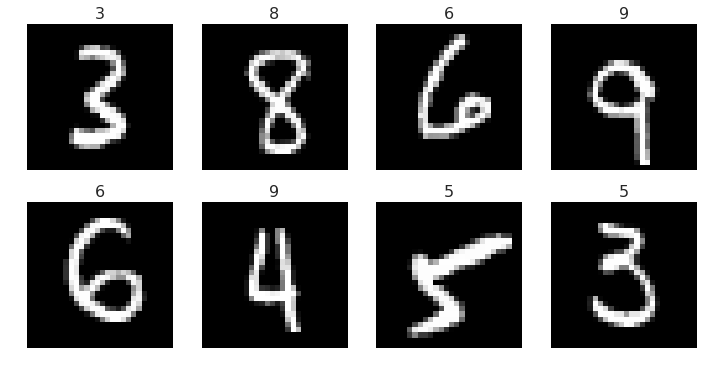

In [32]:
plots(x_imgs[:8], titles=preds_argmax[:8])

This is a one layer neural net, i.e., a logistic regression, and we can actually recreate the same output using scikit learn's logistic regression function.  **TODO**

### DELETE ME Integrate the original code from the notebook into my cells

In [11]:
%%time
fit(net, md, n_epochs=5, crit=loss, opt=opt, metrics=metrics)

  1%|          | 7/782 [00:00<00:21, 35.46it/s, loss=1.23]   

epoch      trn_loss   val_loss   accuracy   
    0      1.213766   1.438505   0.8368    


  1%|          | 7/782 [00:00<00:21, 36.57it/s, loss=1.27]   

    1      1.257663   1.21375    0.8687    


  1%|          | 6/782 [00:00<00:24, 32.17it/s, loss=1.3]     

    2      1.304803   1.252223   0.8562    


  1%|          | 6/782 [00:00<00:23, 32.76it/s, loss=1.22]   

    3      1.223197   0.916236   0.8883    


    4      1.208414   1.096059   0.8778    

CPU times: user 45.4 s, sys: 30.7 s, total: 1min 16s
Wall time: 41.4 s


[1.0960593797355891, 0.87780000000000002]

In [128]:
set_lrs(opt, 1e-2)

In [129]:
fit(net, md, n_epochs=3, crit=loss, opt=opt, metrics=metrics)

A Jupyter Widget

[ 0.       0.07224  0.13539  0.97024]                          
[ 1.       0.05924  0.13015  0.97114]                          
[ 2.       0.04723  0.1316   0.97124]                          



In [133]:
fit(net, md, n_epochs=5, crit=loss, opt=opt, metrics=metrics)

A Jupyter Widget

[ 0.       0.27253  0.21465  0.93939]                         
[ 1.       0.21963  0.23439  0.93481]                         
[ 2.       0.23288  0.18333  0.94705]                         
[ 3.       0.19822  0.1902   0.94636]                         
[ 4.       0.205    0.27594  0.92227]                         



In [134]:
set_lrs(opt, 1e-2)

In [135]:
fit(net, md, n_epochs=3, crit=loss, opt=opt, metrics=metrics)

A Jupyter Widget

[ 0.       0.07269  0.09255  0.97373]                          
[ 1.       0.06316  0.08361  0.97572]                          
[ 2.       0.04525  0.08077  0.97681]                          



In [100]:
t = [o.numel() for o in net.parameters()]
t, sum(t)

([78400, 100, 10000, 100, 1000, 10], 89610)

# Building our own Neural Network for Logistic Regression in PyTorch

Above, we used pytorch's `nn.Linear` to create a linear layer, defined as a matrix multiplication followed by an addition (these are also called `affine transformations`).  Let's try defining this ourselves, by building our own PyTorch class.  A PyTorch module is either a neural net or a layer in a nueral net (since neural nets are modular and a neural net itself can be a "layer" in a larger neural net)

Just as Numpy has `np.matmul` for matrix multiplication (in Python 3, this is equivalent to the `@` operator), PyTorch has `torch.matmul`.  In other words `torch.matmul(x,y) == x@y`

Our PyTorch class needs two things: constructor (says what the parameters are) and a forward method (how to calculate a prediction using those parameters)  The method `forward` describes how the neural net converts inputs to outputs.

In PyTorch, the optimizer knows to try to optimize any attribute of type **Parameter**.  This is why above when we called the SGD optimizer (`optim.sgd`) we had to call the `.parameter()` function on our layers

## Aside about sub classes in python

When creating a class, we can just add functionality to a pre-existing class by calling that class when creating your new class.  Our new class is a subclass of `nn.module` and it is inheriting the properties of the nn.module class.  There is one rule when creating a subclass, you need to include the following line in your init

```python
super().__init__()
```

This tells python to initialize the superclass (in this case the torch module) before initiating the current subclass (in this case LogReg)

## Back to the model

When initializing the random weight in the `get_weights` function, in order to prevent gradient shrinking or gradient explosion we divide the weight matrix by the size of the tensor.

Since we don't know how many dimensions our data will have, we can use `*args`, which when used as a parameter in a function allows us to send a variable-length argument list.  Note that it is the use of the asterisk, \*, that matters, the word `args` is just convention.

In torch `view` is the equivalent of `reshape`, and setting a dimension to -1 tells it to infer the size of that dimension from the other dimensions

```python
>>> x = torch.randn(4, 4)
>>> z = x.view(-1, 8)
>>> z.size()
    torch.Size([2, 8])
```

In [40]:
def get_weights(*dims): return nn.Parameter(torch.randn(dims)/dims[0])
def softmax(x): return torch.exp(x)/(torch.exp(x).sum(dim=1)[:,None])

class LogReg(nn.Module):
    def __init__(self):
        super().__init__()
        self.l1_w = get_weights(28*28, 10)  # Layer 1 weights
        self.l1_b = get_weights(10)         # Layer 1 bias

    def forward(self, x):
        x = x.view(x.size(0), -1)  # equivalent to reshape in numpy 
        x = (x @ self.l1_w) + self.l1_b  # Linear Layer
        x = torch.log(softmax(x)) # Non-linear (LogSoftmax) Layer
        return x

We create our neural net and the optimizer.  (We will use the same loss and metrics from above).

In [42]:
# net2 = LogReg().cuda()
net2 = LogReg()
# opt=optim.Adam(net2.parameters())
opt=optim.SGD(net2.parameters(), 1e-1, momentum=0.9, weight_decay=1e-3)

In [43]:
fit(net2, md, n_epochs=1, crit=loss, opt=opt, metrics=metrics)

epoch      trn_loss   val_loss   accuracy   
    0      0.361127   0.305531   0.9149    



[0.30553094034194944, 0.91490000000000005]

In [48]:
preds2 = predict(net2, md.val_dl)

In [49]:
preds2_argmax = preds2.argmax(axis=1)

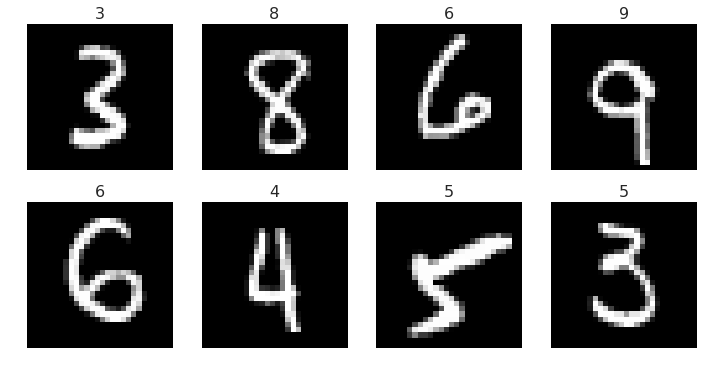

In [51]:
plots(x_imgs[:8], titles=preds2_argmax[:8])

In [50]:
np.mean(preds2_argmax == y_valid)

0.91490000000000005

## Not sure where this code is appropriate

In [47]:
dl = iter(md.trn_dl)

In [48]:
xmb,ymb = next(dl)

In [52]:
print(xmb.shape)
xmb

torch.Size([64, 784])


tensor([[-0.4245, -0.4245, -0.4245,  ..., -0.4245, -0.4245, -0.4245],
        [-0.4245, -0.4245, -0.4245,  ..., -0.4245, -0.4245, -0.4245],
        [-0.4245, -0.4245, -0.4245,  ..., -0.4245, -0.4245, -0.4245],
        ...,
        [-0.4245, -0.4245, -0.4245,  ..., -0.4245, -0.4245, -0.4245],
        [-0.4245, -0.4245, -0.4245,  ..., -0.4245, -0.4245, -0.4245],
        [-0.4245, -0.4245, -0.4245,  ..., -0.4245, -0.4245, -0.4245]])

Wrapping a tensor in `Variable` is how you let PyTorch know to keep track of the differential for this parameter as it will need to perform SGD on it later.

In [49]:
# vxmb = Variable(xmb.cuda())
vxmb = Variable(xmb)
vxmb

tensor([[-0.4245, -0.4245, -0.4245,  ..., -0.4245, -0.4245, -0.4245],
        [-0.4245, -0.4245, -0.4245,  ..., -0.4245, -0.4245, -0.4245],
        [-0.4245, -0.4245, -0.4245,  ..., -0.4245, -0.4245, -0.4245],
        ...,
        [-0.4245, -0.4245, -0.4245,  ..., -0.4245, -0.4245, -0.4245],
        [-0.4245, -0.4245, -0.4245,  ..., -0.4245, -0.4245, -0.4245],
        [-0.4245, -0.4245, -0.4245,  ..., -0.4245, -0.4245, -0.4245]])

In [53]:
preds = net2(vxmb).exp(); preds[:3]

tensor([[ 6.3626e-06,  1.2105e-06,  2.8107e-06,  7.3512e-06,  3.9612e-01,
          1.7406e-04,  2.1466e-04,  3.4038e-03,  1.5325e-02,  5.8474e-01],
        [ 2.2152e-04,  5.5954e-02,  5.2104e-04,  1.0306e-02,  6.7856e-05,
          6.0536e-01,  4.6721e-04,  7.0908e-02,  5.2787e-02,  2.0341e-01],
        [ 2.0823e-02,  2.3426e-05,  1.9553e-04,  5.9046e-01,  1.0586e-06,
          1.9001e-03,  5.4244e-06,  3.8488e-01,  8.8515e-06,  1.7022e-03]])

In [54]:
preds.shape

torch.Size([64, 10])

In [56]:
preds.data.max(1)

(tensor([ 0.5847,  0.6054,  0.5905,  0.9803,  0.9996,  0.9835,  0.9921,
          0.4827,  0.9459,  0.8103,  0.6352,  0.9750,  0.9640,  0.9042,
          0.9222,  0.9806,  0.8631,  0.9998,  0.9300,  0.9923,  0.9897,
          0.9733,  0.9717,  0.9304,  0.8534,  0.9967,  0.9979,  0.9072,
          0.9595,  0.9741,  0.9957,  0.9997,  0.5420,  0.9958,  0.7623,
          0.9162,  0.9322,  0.9749,  0.9908,  0.6102,  0.9590,  0.8889,
          0.9988,  0.9977,  0.6241,  0.8398,  0.9533,  0.5453,  0.9243,
          0.9640,  0.9956,  0.9500,  0.8289,  0.9947,  0.8073,  0.7368,
          0.9902,  0.9932,  0.9977,  0.7467,  0.9724,  0.9951,  0.9824,
          0.9456]),
 tensor([ 9,  5,  3,  3,  3,  1,  3,  4,  8,  8,  8,  9,  1,  8,
          1,  7,  4,  0,  0,  7,  7,  3,  5,  3,  6,  6,  6,  8,
          1,  1,  1,  0,  4,  5,  7,  9,  1,  3,  1,  2,  0,  2,
          2,  2,  4,  3,  6,  9,  9,  8,  2,  8,  2,  6,  5,  4,
          7,  7,  3,  8,  6,  6,  8,  7]))

In [55]:
preds.max(1)

(tensor([ 0.5847,  0.6054,  0.5905,  0.9803,  0.9996,  0.9835,  0.9921,
          0.4827,  0.9459,  0.8103,  0.6352,  0.9750,  0.9640,  0.9042,
          0.9222,  0.9806,  0.8631,  0.9998,  0.9300,  0.9923,  0.9897,
          0.9733,  0.9717,  0.9304,  0.8534,  0.9967,  0.9979,  0.9072,
          0.9595,  0.9741,  0.9957,  0.9997,  0.5420,  0.9958,  0.7623,
          0.9162,  0.9322,  0.9749,  0.9908,  0.6102,  0.9590,  0.8889,
          0.9988,  0.9977,  0.6241,  0.8398,  0.9533,  0.5453,  0.9243,
          0.9640,  0.9956,  0.9500,  0.8289,  0.9947,  0.8073,  0.7368,
          0.9902,  0.9932,  0.9977,  0.7467,  0.9724,  0.9951,  0.9824,
          0.9456]),
 tensor([ 9,  5,  3,  3,  3,  1,  3,  4,  8,  8,  8,  9,  1,  8,
          1,  7,  4,  0,  0,  7,  7,  3,  5,  3,  6,  6,  6,  8,
          1,  1,  1,  0,  4,  5,  7,  9,  1,  3,  1,  2,  0,  2,
          2,  2,  4,  3,  6,  9,  9,  8,  2,  8,  2,  6,  5,  4,
          7,  7,  3,  8,  6,  6,  8,  7]))

In [25]:
preds = preds.data.max(1)[1]; preds


 5
 2
 4
 1
 8
 8
 3
 4
 2
 7
 1
 1
 7
 9
 3
 4
 3
 0
 1
 4
 3
 3
 6
 8
 9
 0
 9
 5
 2
 4
 7
 9
 0
 2
 5
 2
 9
 9
 6
 9
 4
 2
 2
 7
 1
 5
 5
 9
 0
 7
 4
 0
 9
 1
 1
 4
 7
 0
 9
 0
 4
 4
 0
 7
[torch.cuda.LongTensor of size 64 (GPU 0)]

# Writing Our Own Training Loop

As a reminder, this is what we did above to write our own logistic regression class (as a pytorch neural net):

In [52]:
# Our code from above
class LogReg(nn.Module):
    def __init__(self):
        super().__init__()
        self.l1_w = get_weights(28*28, 10)  # Layer 1 weights
        self.l1_b = get_weights(10)         # Layer 1 bias

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = x @ self.l1_w + self.l1_b 
        return torch.log(softmax(x))

# net2 = LogReg().cuda()
net2 = LogReg()
# opt=optim.Adam(net2.parameters())
opt=optim.SGD(net2.parameters(), 1e-1, momentum=0.9, weight_decay=1e-3)

fit(net2, md, n_epochs=1, crit=loss, opt=opt, metrics=metrics)

epoch      trn_loss   val_loss   accuracy   
    0      0.37501    0.335794   0.9129    



[0.33579445953369141, 0.91290000000000004]

Above, we are using the fastai method `fit` to train our model.  Now we will try writing the training loop ourselves.

We will use the LogReg class we created, as well as the same loss function, learning rate, and optimizer as before:

In [61]:
# net2 = LogReg().cuda()
net2 = LogReg()
loss=nn.NLLLoss()
# learning_rate = 1e-3
opt=optim.SGD(net2.parameters(), 1e-1, momentum=0.9, weight_decay=1e-3)
# optimizer=optim.Adam(net2.parameters(), lr=learning_rate)

md is the ImageClassifierData object we created above.  We want an iterable version of our training data 

In [62]:
dl = iter(md.trn_dl) # Data loader

First, we will do a **forward pass**, which means computing the predicted `y` by passing `x` to the model.

In [63]:
xt, yt = next(dl)
# y_pred = net2(Variable(xt).cuda())
y_pred = net2(Variable(xt))

We can check the loss:

In [64]:
# l = loss(y_pred, Variable(yt).cuda())
l = loss(y_pred, Variable(yt))
print(l)

tensor(2.2973)


We may also be interested in the accuracy.  We don't expect our first predictions to be very good, because the weights of our network were initialized to random values.  Our goal is to see the loss decrease (and the accuracy increase) as we train the network:

In [65]:
np.mean(to_np(y_pred).argmax(axis=1) == to_np(yt))

0.125

Now we will use the optimizer to calculate which direction to step in.  That is, how should we update our weights to try to decrease the loss?

Pytorch has an automatic differentiation package ([autograd](http://pytorch.org/docs/master/autograd.html)) that takes derivatives for us, so we don't have to calculate the derivative ourselves!  We just call `.backward()` on our loss to calculate the direction of steepest descent (the direction to lower the loss the most).

In [66]:
# Before the backward pass, use the optimizer object to zero all of the
# gradients for the variables it will update (which are the learnable weights
# of the model)
opt.zero_grad()

# Backward pass: compute gradient of the loss with respect to model parameters
l.backward()

# Calling the step function on an Optimizer makes an update to its parameters
opt.step()

Now, let's make another set of predictions and check if our loss is lower:

In [67]:
xt, yt = next(dl)
# y_pred = net2(Variable(xt).cuda())
y_pred = net2(Variable(xt))

In [68]:
# l = loss(y_pred, Variable(yt).cuda())
l = loss(y_pred, Variable(yt))
print(l)

tensor(2.1683)


Note that we are using **stochastic** gradient descent, so the loss is not guaranteed to be strictly better each time.  The stochasticity comes from the fact that we are using **mini-batches**; we are just using 64 images to calculate our prediction and update the weights, not the whole dataset.

In [69]:
np.mean(to_np(y_pred).argmax(axis=1) == to_np(yt))

0.390625

If we run several iterations in a loop, we should see the loss decrease and the accuracy increase with time.

In [70]:
for t in range(100):
    xt, yt = next(dl)
#     y_pred = net2(Variable(xt).cuda())
    y_pred = net2(Variable(xt))
#     l = loss(y_pred, Variable(yt).cuda())
    l = loss(y_pred, Variable(yt))
    
    if t % 10 == 0:
        accuracy = np.mean(to_np(y_pred).argmax(axis=1) == to_np(yt))
        print("loss: ", l.data[0], "\t accuracy: ", accuracy)

    opt.zero_grad()
    l.backward()
    opt.step()

loss:  tensor(2.2301) 	 accuracy:  0.265625
loss:  tensor(0.6034) 	 accuracy:  0.84375
loss:  tensor(0.6776) 	 accuracy:  0.75
loss:  tensor(0.6230) 	 accuracy:  0.828125
loss:  tensor(0.4466) 	 accuracy:  0.875
loss:  tensor(0.3114) 	 accuracy:  0.921875
loss:  tensor(0.4596) 	 accuracy:  0.859375
loss:  tensor(0.3602) 	 accuracy:  0.90625
loss:  tensor(0.4485) 	 accuracy:  0.890625
loss:  tensor(0.3115) 	 accuracy:  0.890625


### Put it all together in a training loop

In [71]:
def score(x, y):
    y_pred = to_np(net2(V(x)))
    return np.sum(y_pred.argmax(axis=1) == to_np(y))/len(y_pred)

In [118]:
# net2 = LogReg().cuda()
net2 = LogReg()
loss=nn.NLLLoss()
learning_rate = 1e-2
optimizer=optim.SGD(net2.parameters(), lr=learning_rate)
trn_batches = md.trn_ds.n // md.bs + int(md.trn_ds.n % md.bs > 0)
val_batches = md.val_ds.n // md.bs + int(md.val_ds.n % md.bs > 0)

for epoch in range(1):
    losses=[]
    dl = iter(md.trn_dl)
#     for t in range(len(dl)):
    for t in range(trn_batches):
        # Forward pass: compute predicted y and loss by passing x to the model.
        xt, yt = next(dl)
        y_pred = net2(V(xt))
        l = loss(y_pred, V(yt))
        losses.append(l)

        # Before the backward pass, use the optimizer object to zero all of the
        # gradients for the variables it will update (which are the learnable weights of the model)
        optimizer.zero_grad()

        # Backward pass: compute gradient of the loss with respect to model parameters
        l.backward()

        # Calling the step function on an Optimizer makes an update to its parameters
        optimizer.step()
    
    val_dl = iter(md.val_dl)
    val_scores = [score(*next(val_dl)) for i in range(val_batches)]
#     val_scores = [score(*next(val_dl)) for i in range(len(val_dl))]
    print(np.mean(val_scores))

0.874104299363


# Stochastic Gradient Descent

Nearly all of deep learning is powered by one very important algorithm: **stochastic gradient descent (SGD)**. SGD can be seeing as an approximation of **gradient descent (GD)**. In GD you have to run through all the samples in your training set to do a single itaration. In SGD you use only a subset of training samples to do the update for a parameter in a particular iteration. The subset used in each iteration is called a batch or minibatch.

Now, instead of using the optimizer, we will do the optimization ourselves!

In [120]:
# net2 = LogReg().cuda()
net2 = LogReg()
loss_fn=nn.NLLLoss()
lr = 1e-2
w,b = net2.l1_w,net2.l1_b
trn_batches = md.trn_ds.n // md.bs + int(md.trn_ds.n % md.bs > 0)
val_batches = md.val_ds.n // md.bs + int(md.val_ds.n % md.bs > 0)

for epoch in range(3):
    losses=[]
    dl = iter(md.trn_dl)
#     for t in range(len(dl)):
    for t in range(trn_batches):
        xt, yt = next(dl)
        y_pred = net2(V(xt))
#         l = loss(y_pred, Variable(yt).cuda())
        l = loss(y_pred, Variable(yt))
        losses.append(loss)

        # Backward pass: compute gradient of the loss with respect to model parameters
        l.backward()
        w.data -= w.grad.data * lr
        b.data -= b.grad.data * lr
        
        w.grad.data.zero_() # suffix underscore just means do the operation in place instead of creating new variable
        b.grad.data.zero_()   

    val_dl = iter(md.val_dl)
    val_scores = [score(*next(val_dl)) for i in range(val_batches)]
#     val_scores = [score(*next(val_dl)) for i in range(len(val_dl))]
    print(np.mean(val_scores))

0.871218152866
0.885250796178
0.893113057325


# Addenda

To see the number of parameters per layer in my neural network by calling the `.parameters()` method on my neural network.  This creates a generator object which will go through each layer,  If I then iterate through the generator I can extract the number of elements in each layer using `.numel()`

In [126]:
t = [o.numel() for o in net.parameters()]
t, sum(t)

([7840, 10], 7850)

## L2 Regularization and weight decay

Remember that we calculate our parameters by minimizing a loss function, which has the general form of :

$$ \ell = \sum\limits_{i=1}^n\left(Y_i - \sum\limits_{j=1}^p X_{ij} w_j\right)^2 $$

One way to reduce the overfitting of our model is to penalize all non-zero weights.  We can do this by adding a term to our loss function:

$$ \ell = \sum\limits_{i=1}^n\left(Y_i - \sum\limits_{j=1}^p X_{ij} w_j\right)^2 + \ell_{reg}(w)$$

We don't want to penalize weights with a value zero, as that is the same as not having any parameter, just the degree to which the weights differ from zero.  Two standard ways of doing this are L1 regularization, also known as lasso regression (least absolute shrinkage and selection operator), and L2 regularization.  L1 regularization uses the absolute value of the weights and L2 uses the square of the weights.  In both cases you don't want to add the entire value of the weights to the loss function, just some small percentage, on the order of $10^{-4}$ to $10^{-6}$, which we can call $\alpha$.

$$ \ell_{L1} = \sum\limits_{i=1}^n\left(Y_i - \sum\limits_{j=1}^p X_{ij} w_j\right)^2 + \alpha\sum\limits_{j=1}^p\left|w_j\right| $$

$$ \ell_{L2} = \sum\limits_{i=1}^n\left(Y_i - \sum\limits_{j=1}^p X_{ij} w_j\right)^2 + \alpha\sum\limits_{j=1}^p w_j^2 $$

When working with neural networks we are often concerned with the gradient of the loss, which for L2 is easy to calculate

$$\Delta_{L2} = 2\alpha w $$

In neural networks, this L2 gradient is referred to as the weight decay.  

Let's build a lsightly deeper simple neural network with and without weight decay

In [27]:
net = nn.Sequential(
    nn.Linear(28*28, 100),
    nn.ReLU(),
    nn.Linear(100, 100),
    nn.ReLU(),
    nn.Linear(100, 10),
    nn.LogSoftmax()
)
md = ImageClassifierData.from_arrays(PATH, (x,y), (x_valid, y_valid))
loss=nn.NLLLoss()
metrics=[accuracy]

In [28]:
opt=optim.SGD(net.parameters(), 1e-1, momentum=0.9)

In [29]:
fit(net, md, n_epochs=3, crit=loss, opt=opt, metrics=metrics)

  1%|          | 4/782 [00:00<00:36, 21.48it/s, loss=0.294]  

epoch      trn_loss   val_loss   accuracy   
    0      0.301842   0.24314    0.9398    


  1%|          | 4/782 [00:00<00:37, 20.89it/s, loss=0.244]  

    1      0.246357   0.264417   0.9415    


    2      0.24186    0.250231   0.9451    



[0.25023104345500469, 0.94510000000000005]

In [31]:
net = nn.Sequential(
    nn.Linear(28*28, 100),
    nn.ReLU(),
    nn.Linear(100, 100),
    nn.ReLU(),
    nn.Linear(100, 10),
    nn.LogSoftmax()
)
opt=optim.SGD(net.parameters(), 1e-1, momentum=0.9, weight_decay=1e-3)

In [32]:
fit(net, md, n_epochs=3, crit=loss, opt=opt, metrics=metrics)

  1%|          | 4/782 [00:00<00:36, 21.27it/s, loss=0.274]  

epoch      trn_loss   val_loss   accuracy   
    0      0.273734   0.244744   0.9298    


  1%|          | 4/782 [00:00<00:37, 20.94it/s, loss=0.231]  

    1      0.232462   0.275376   0.9212    


    2      0.231492   0.191098   0.9475    



[0.19109784487709403, 0.94750000000000001]

You might expect the training loss to be worse with weight decay, but what might be happening here is that weight decay is making the loss function easier to optimize on a per epoch level, resulting in a lower training loss.  But in the end you would expect the training loss with weight decay to be worse (larger value) than the training loss without weight decay.

However, weight decay should improve the overall loss on the validation set, which it does in this case.  This is because the purpose of the weight decay is to decrease overfitting, which should make the model more generalizable.